# Кластеризация
## K-means

N образцов делятся на заданное количество K кластеров C с одинаковой дисперсией. У каждого кластера C есть центроид $\mu$ - центр масс группы. В процессе обучения минимизируется критерий

$$
\sum_{i=0}^n \min_{\mu_j \in C} (||x_i-\mu_j||^2)
$$

Недостатки:
- предполагается, что кластеры выпуклы и изотропны, плохо работает с удлиненным ископлениями и скоплениями неправильно формы
- проклятие размерности

In [1]:
import numpy as np
from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

In [3]:
import time
from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
print(t_batch)

0.04900002479553223


Присвоение кластерам

In [5]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)

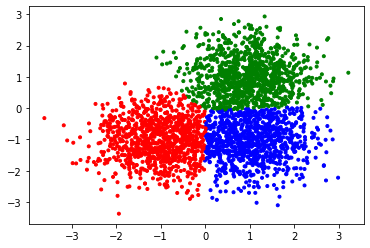

In [13]:
import matplotlib.pyplot as plt
import numpy as np

colors = np.where(k_means_labels == 0, 'blue', np.where(k_means_labels == 1, 'red', 'green'))

plt.scatter(X[:, 0], X[:, 1], color=colors, marker='.')

Реализация minibatch для ускорения вычислений

In [4]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=3,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0
print(t_mini_batch)

0.14099955558776855


## Affinity Propagation
Между экземплярами устанавливается два соответсвия: насколько экземпляр считает, что соотвтетсвия принадлжает его классу, насколько окружающие считают, что он соответствует своему классу. На основании обмена этими данными происходит обучение

In [15]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=300, centers=centers, cluster_std=0.5, random_state=0
)

In [16]:
af = AffinityPropagation(preference=-50, random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

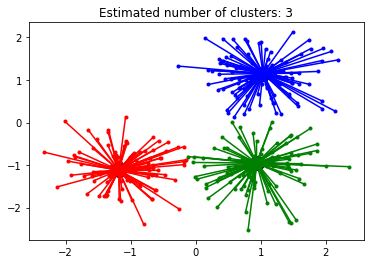

In [18]:
from itertools import cycle

plt.figure()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Mean Shift
Выбираются кандидаты для центроидов, задается окрестность соседних точек $N(x_i)$. Каждый кандидат для центроидов обновляется по закону:

$$
x_i^{t+1} = m(x_i^t)
$$

$$
m(x_i) = \frac{\sum_{x_j\in N(x_i)}K(x_j-x_i)x_j}{sum_{x_j\in N(x_i)}K(x_j-x_i)}
$$

In [19]:
from sklearn.cluster import MeanShift, estimate_bandwidth

centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

In [20]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3


Text(0.5, 1.0, 'Estimated number of clusters: 3')

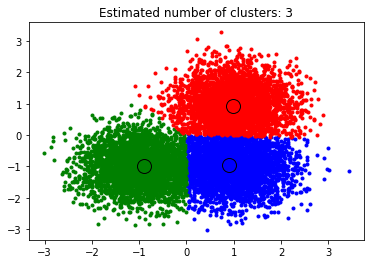

In [21]:
plt.figure()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)

## Agglomerative Clustering

Объект AgglomerativeClustering выполняет иерархическую кластеризацию по принципу «снизу вверх»: каждый объект начинается в своем собственном кластере, и кластеры последовательно объединяются. Критерии связи определяют метрику, используемую для стратегии слияния:

- Ward минимизирует сумму квадратов разностей во всех кластерах;

- Maximum or complete linkage минимизирует максимальное расстояние между наблюдениями пар кластеров.

- Average linkage минимизирует среднее значение расстояний между всеми наблюдениями пар кластеров.

- Single linkage минимизирует расстояние между ближайшими наблюдениями пар кластеров.

In [22]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [4, 2], [4, 4], [4, 0]])
clustering = AgglomerativeClustering().fit(X)
clustering

clustering.labels_

array([1, 1, 1, 0, 0, 0], dtype=int64)

## DBSCAN

Определяются плотные группы (минимальное количество элементов с заданным макисмальным расстоянием между ними). Каждая плотная группа- кластер. Не входящие в группы - не принадлежат ни одному из кластеров. Хоршо подходит для кластеров сложной формы.

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

In [24]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

Text(0.5, 1.0, 'Estimated number of clusters: 3')

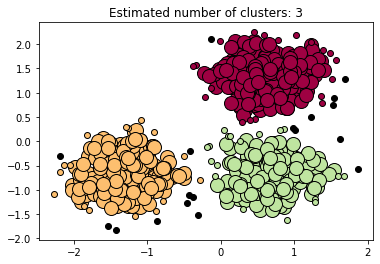

In [25]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)

## Метрики

- однородность: каждый кластер содержит только членов одного класса;
- полнота: все члены данного класса относятся к одному и тому же кластеру
- V-мера

$$
v = \frac{(1+\beta)\times homogenity \times completness}{ \beta \times homogenity \times completness}
$$

In [26]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]

metrics.homogeneity_score(labels_true, labels_pred)

0.420619835714305

In [27]:
metrics.completeness_score(labels_true, labels_pred)

0.420619835714305

In [28]:
metrics.v_measure_score(labels_true, labels_pred, beta=0.6)

0.5467344787062375